# (SelfEx-LLM) CoT Explainability for RAG

basierend auf: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=11053836&tag=1


In [1]:
import sys
from pathlib import Path

# Füge das Projektverzeichnis (mit `src/`) dem Python-Pfad hinzu, egal von wo das Notebook gestartet wird.
project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / 'src').exists()), None)
if project_root is None:
    raise RuntimeError("\"src\"-Verzeichnis nicht gefunden. Bitte Notebook im Projekt laufen lassen.")
root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)


In [2]:
from src.modules.explainers.cot_explainable import CoTExplainable, ExplainableAnswer, _format_documents
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.llm.llm_client import LLMClient
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader, format_medmcqa_question
from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.evaluation.cot_metrics import CoTEvaluator

import numpy as np
import tomllib, matplotlib.pyplot as plt

### Real data example

In [3]:
config_path = project_root / "config.toml"
config = {}

if config_path.exists():
    with open(config_path, "rb") as f:
        config = tomllib.load(f)

medmcqa_config = config.get("medmcqa") or {}
rag_config = config.get("rag") or {}
llm_config = config.get("llm") or {}

llm_model = llm_config.get("model", "gemma3:4b")
llm_provider = llm_config.get("provider", "ollama")

client = LLMClient(provider=llm_provider, model_name=llm_model)
explain_client = LLMClient(provider=llm_provider, model_name=llm_model, structured_output=ExplainableAnswer)

SPLIT = medmcqa_config.get("split", "val")
LIMIT = medmcqa_config.get("n_qa_questions", 10)
PERSIST_DIR = project_root / "data" / "vector_db_statpearls"
NUM_HOPS = rag_config.get("n_hops", 2)

kg_capable_ids = medmcqa_config.get("kg_capable", [])

In [4]:
stat_loader = StatPearlsDataLoader(root_dir=str(project_root / "data"))
documents, stats = stat_loader.setup()

rag_engine = RAGEngine(persist_dir=str(PERSIST_DIR))
rag_engine.setup(documents=documents)

multi_hop = MultiHopRAGEngine(rag_engine=rag_engine, llm_client=client, num_hops=NUM_HOPS)
cot_evaluator = CoTEvaluator()

Loading existing vector store from /Users/benediktveith/Documents/Uni/Semester 7/XAI/xai-rag/data/vector_db_statpearls...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


In [36]:
med_loader = MedMCQADataLoader()
questions = med_loader.setup(split=SPLIT, as_documents=False, limit=LIMIT, ids=kg_capable_ids)

if not questions:
    raise RuntimeError("No MedMCQA questions loaded.")

results = []
llm = client.get_llm()
for item in questions:
    question_text = format_medmcqa_question(item)
    if not question_text:
        continue

    retrieval_query = question_text.strip()
    trace, all_documents = multi_hop.run_and_trace(retrieval_query, extra='Only answer based on your context not your knowledge. Do not include any explanations, reasoning, or extra fields.\n Example: Final Answer: B: Housing')

    documents_for_explanation = all_documents

    context_blocks = []
    for doc in documents_for_explanation:
        content = getattr(doc, "page_content", None)
        if content is None:
            content = str(doc)
        context_blocks.append(str(content).strip())

    context = "\n\n".join([c for c in context_blocks if c])
    final_answer = trace["final_answer"]

    explainer = CoTExplainable(llm_client=explain_client)
    explanation = explainer.explain(query=question_text, answer=final_answer, documents=documents_for_explanation)
    metrics = explainer.metrics()
    cot_metrics = cot_evaluator.evaluate(explanation, documents_for_explanation, predicted_answer=final_answer)
    similarity = cot_evaluator.similarity_matrix(explanation, documents_for_explanation)

    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "trace": trace,
            "explanation": explanation,
            "metrics": metrics,
            "cot_metrics": cot_metrics,
            "similarity": similarity,
            "documents": documents_for_explanation,
        }
    )


--- Starting Multi-Hop Search for: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad' ---

[ Hop 1 ]
Executing search with query: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad'
Generating next query...

[ Hop 2 ]
Executing search with query: '“osteopetrosis symptoms”'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: I cannot answer this question based on the provided information. ---
--- Multi-Hop Context: 

 ('<doc id="chunk-1-1" from_hop="1" search_query="Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation\n\nOptions:\nA: bc\nB: c\nC: ac\nD: ad">\n[Document(id=\'1eb7a40b-ddf9-4884-98e7-b57658414621\', metada

In [33]:
import html
from IPython.display import display, HTML
def highlight_text(text, snippets):
    out = html.escape(text.lower())
    for s in snippets:
        out = out.replace(
            html.escape(s.lower()),
            f"<mark>{html.escape(s)}</mark>"
        )
    return out

=== Result 1 ===
Question: Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad


------------
Explain metrics: {'duration_seconds': 70.20100199989974, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0036
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0036
  • Max Entailment: 0.0036
  • Avg Neutral: 0.9946
  • Avg Contradiction: 0.0018
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.004)
        "Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple ..."

evidence: Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation
  support: chunk-1-1
  rationale: The document lists frontal bossing as a characteristic of childhood osteopetrosis.
Reasoning steps:
    step 1: The context describes several characteristics of childhood osteopetrosis.


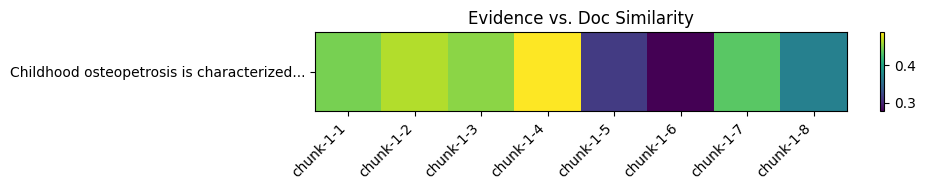

=== Result 2 ===
Question: The triad of hypertension, bradycardia and irregular respiration is seen in:

Options:
A: Cushing's reflex
B: Bezold-Zarisch reflex
C: Herring-Bruer reflex
D: Bainbridge's reflex


------------
Explain metrics: {'duration_seconds': 66.86209995811805, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0015
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0015
  • Max Entailment: 0.0015
  • Avg Neutral: 0.9983
  • Avg Contradiction: 0.0002
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.001)
        "The triad of hypertension, bradycardia and irregular respiration is seen in the ..."

evidence: The triad of hypertension, bradycardia and irregular respiration is seen in the Bezold-Zarisch reflex.
  support: chunk-1-1
  rationale: Document chunk-1-1 explicitly states that the triad of hypertension, bradycardia and irregular respiration is seen in the Bezold-Zarisch reflex.
Reasoning steps:
    step 1: The triad of hypertension, bradycardia and irregular respiration is seen in the Bezold-Zarisch reflex.
      quote: Bezold-Zarisch reflex


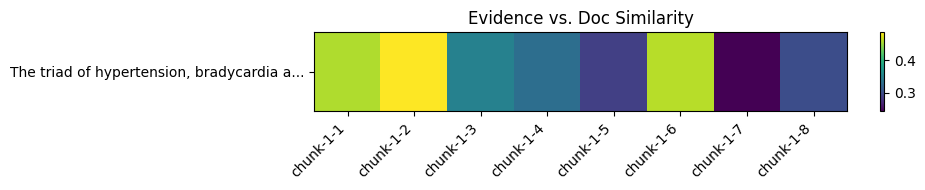

=== Result 3 ===
Question: Cause of clostridium difficle associated diarrhea ?

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use


------------
Explain metrics: {'duration_seconds': 88.64986366732046, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9794
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.6426
  • Max Entailment: 0.9794
  • Avg Neutral: 0.2355
  • Avg Contradiction: 0.1220
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.979)
        "Patients developing diarrhea while receiving treatment with antibiotics should b..."
    [1] ENTAILMENT (ent: 0.940)
        "Colonic flora is changed when receiving treatment with antibiotics, making it su..."
    [2] NEUTRAL (ent: 0.009)
        "diets with higher lactose intake"

evidence: Patients developing diarrhea while receiving treatment with antibiotics should be assessed for Clostridium difficile infection.
  support: chunk-1-1
  rationale: Document chunk-1-1 directly states that antibiotic use is a cause of Clostridium difficile infection.
Reasoning steps:
    step 1: The document states t

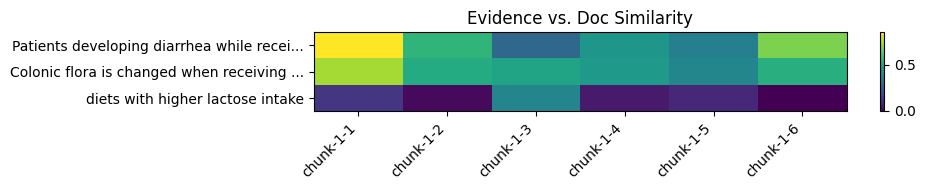

=== Result 4 ===
Question: Cause of Clostridium difficile associated diarrhea is

Options:
A: Trauma
B: Dairy products
C: Fried rice
D: Antibiotic use


------------
Explain metrics: {'duration_seconds': 53.919656791724265, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0125
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0125
  • Max Entailment: 0.0125
  • Avg Neutral: 0.9664
  • Avg Contradiction: 0.0210
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.013)
        "Patients developing diarrhea while receiving treatment with antibiotics should b..."

evidence: Patients developing diarrhea while receiving treatment with antibiotics should be assessed for Clostridium difficile infection. Colonic flora is changed when receiving treatment with antibiotics, making it susceptible to Clostridium difficile infection resulting in mild to severe forms of diarrhea.
  support: chunk-1-1
  rationale: This document directly states that antibiotic use changes the colonic flora, making it susceptible to Clostridium difficile infection and diarrhea.
Reasoning steps:
    step 1: The pro

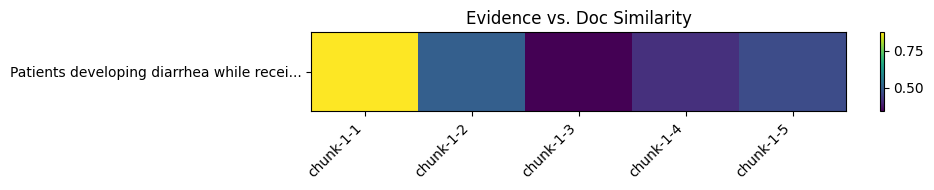

=== Result 5 ===
Question: A patient with previous spells of diplopia, ataxia, dysahria, and dizziness becomes acutely comatose. The most likely cause is

Options:
A: Basilar aery thrombosis
B: Subarachnoid hemorrhage
C: Carotid occlusion
D: Cerebellar hemorrhage


------------
Explain metrics: {'duration_seconds': 75.9958016667515, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0022
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0015
  • Max Entailment: 0.0022
  • Avg Neutral: 0.9976
  • Avg Contradiction: 0.0009
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.002)
        "A patient with previous spells of diplopia, ataxia, dysahria, and dizziness beco..."
    [1] NEUTRAL (ent: 0.001)
        "Several documents describe a patient presenting with symptoms including diplopia..."

evidence: A patient with previous spells of diplopia, ataxia, dysahria, and dizziness becomes acutely comatose.
  support: chunk-1-1
  rationale: This statement describes the patient's presentation, which is the basis for determining the most likely cause.
Reasoning steps:
    step 1: Several documents describe a patient presenting with symptoms including diplopia, ataxia, dysarthria, and dizziness, lead

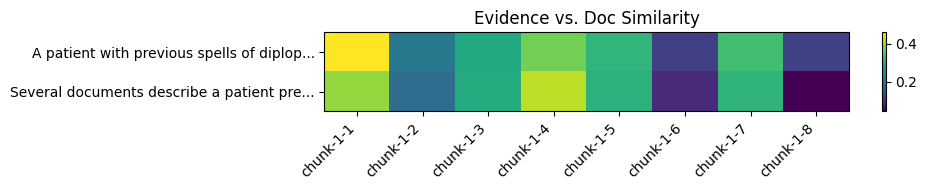

=== Result 6 ===
Question: Standard site for primary bone graft -a) Pelvisb) Greater trochanterc) Medial malleolusd) Lateral melleoluse) Fibula

Options:
A: a
B: b
C: ab
D: ae


------------
Explain metrics: {'duration_seconds': 78.30087858298793, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0107
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0107
  • Max Entailment: 0.0107
  • Avg Neutral: 0.9877
  • Avg Contradiction: 0.0016
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.011)
        "Pelvis"

evidence: Pelvis
  support: chunk-1-1
  rationale: Document chunk-1-1 explicitly lists 'Pelvis' as a standard site for primary bone graft.
Reasoning steps:
    step 1: The context provides multiple documents discussing bone grafting sites.


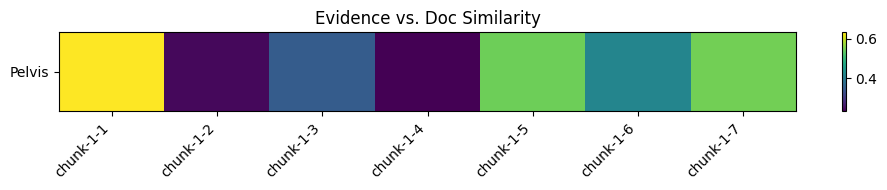

=== Result 7 ===
Question: Which of the following is a known adverse effect of lithium?

Options:
A: Agranulocytosis
B: Altered judgement
C: Aplastic anemia
D: Hypothyroidism


------------
Explain metrics: {'duration_seconds': 60.00532449968159, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0066
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0066
  • Max Entailment: 0.0066
  • Avg Neutral: 0.9914
  • Avg Contradiction: 0.0021
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.007)
        "Agranulocytosis"

evidence: Agranulocytosis
  support: chunk-1-1
  rationale: Document chunk-1-1 explicitly states 'Agranulocytosis' as a known adverse effect of lithium.
Reasoning steps:
    step 1: The context provides multiple documents discussing the adverse effects of lithium.
    step 2: Document chunk-1-1 lists 'Agranulocytosis' as a known adverse effect of lithium.
      quote: Agranulocytosis


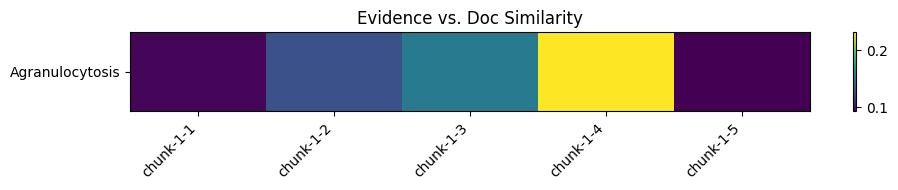

=== Result 8 ===
Question: A 19-year-old presents at the emergency department with high fever, severe headache, nausea, and stiff neck for 3 days. The attending physician suspects meningitis and obtains a sample of CSF using a lumbar puncture. From which of the following spaces was the CSF collected?

Options:
A: Epidural space
B: Subdural space
C: Subarachnoid space
D: Pretracheal space


------------
Explain metrics: {'duration_seconds': 75.2625923329033, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.4262
  • Can Derive Answer: ✗ No
  • Overall Label: contradiction
  • Avg Entailment: 0.4262
  • Max Entailment: 0.4262
  • Avg Neutral: 0.0424
  • Avg Contradiction: 0.5313
  • Per-Evidence Scores:
    [0] CONTRADICTION (ent: 0.426)
        "CSF using a lumbar puncture"
    [1] CONTRADICTION (ent: 0.426)
        "CSF using a lumbar puncture"

evidence: CSF using a lumbar puncture
  support: chunk-1-1
  rationale: The lumbar puncture procedure is performed in the subarachnoid space to obtain CSF.
Reasoning steps:
    step 1: The CSF is obtained using a lumbar puncture.
      quote: obtains a sample of CSF using a lumbar puncture
    step 2: The subarachnoid space is the space where the lumbar puncture is performed to collect CSF.
      quote: CSF using a lumbar puncture
evidence: CSF using a lumbar puncture
  support: chunk-1-2
  ratio

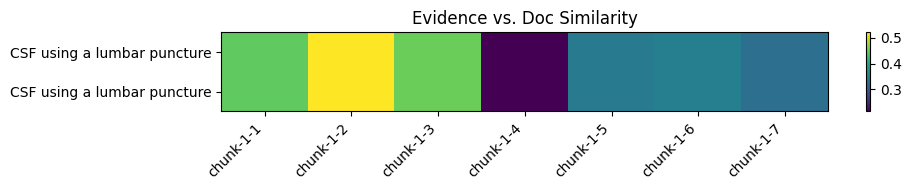

=== Result 9 ===
Question: When nitrates are combined with calcium channel blockers:

Options:
A: Aerial pressure will decrease
B: Hea rate will increase
C: Ejection time will decrease
D: End-diastolic volume will increase


------------
Explain metrics: {'duration_seconds': 63.306409707758576, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9973
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9973
  • Max Entailment: 0.9973
  • Avg Neutral: 0.0025
  • Avg Contradiction: 0.0002
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.997)
        "Nitrates relax vascular smooth muscle, leading to dilation of veins primarily; t..."

evidence: Nitrates relax vascular smooth muscle, leading to dilation of veins primarily; this decreases cardiac preload.
  support: chunk-1-1
  rationale: Document chunk-1-1 explicitly states that nitrates decrease cardiac preload by relaxing vascular smooth muscle and dilating veins.
Reasoning steps:
    step 1: Nitrates relax vascular smooth muscle, leading to dilation of veins primarily; this decreases cardiac preload.
      quote: Nitrates: Nitrates relax vascular smooth muscle, leading to dilation of veins prim

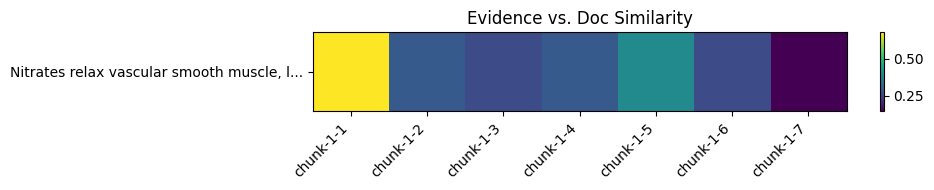

=== Result 10 ===
Question: Vitamin B12 and folic acid supplementation in megaloblastic anemia leads to the improvement of anemia due to

Options:
A: Increased DNA synthesis in bone marrow
B: Increased hemoglobin production
C: Erythroid hyperplasia
D: Increased iron absorption


------------
Explain metrics: {'duration_seconds': 56.64451083308086, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0020
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0020
  • Max Entailment: 0.0020
  • Avg Neutral: 0.9614
  • Avg Contradiction: 0.0366
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.002)
        "Vitamin B12 and folic acid supplementation in megaloblastic anemia leads to the ..."

evidence: Vitamin B12 and folic acid supplementation in megaloblastic anemia leads to the improvement of anemia
  support: chunk-1-1
  rationale: The provided context explicitly states that vitamin B12 and folic acid supplementation improves anemia in megaloblastic anemia.
Reasoning steps:
    step 1: The context discusses vitamin B12 and folic acid supplementation in megaloblastic anemia and their impact on improving anemia.
      quote: Vitamin B12 and folic acid supplementation in megaloblastic anemia leads to the improv

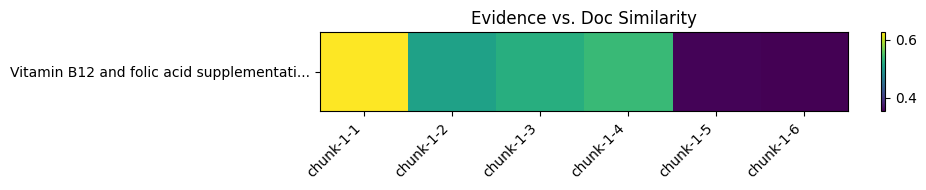

=== Result 11 ===
Question: Pain during inflammation is mediated by

Options:
A: Nitric oxide
B: Leukotriene B4
C: Bradykinin
D: Chemokines


------------
Explain metrics: {'duration_seconds': 63.875796999782324, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0026
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0018
  • Max Entailment: 0.0026
  • Avg Neutral: 0.9960
  • Avg Contradiction: 0.0022
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.003)
        "Substances Released When Tissue is Injured"
    [1] NEUTRAL (ent: 0.001)
        "Substances released include vasoactive peptides such as calcitonin, gene-related..."

evidence: Substances Released When Tissue is Injured
  support: chunk-1-1
  rationale: Chunk 1-1 lists substances released when tissue is injured, including bradykinin.
Reasoning steps:
    step 1: The context discusses substances released during inflammation that mediate pain.
evidence: Substances released include vasoactive peptides such as calcitonin, gene-related protein, neurokinin A, substance P, and mediators such as bradykinin
  suppo

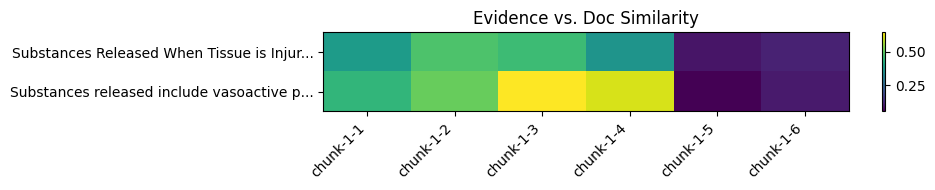

=== Result 12 ===
Question: A patient with heart failure developed ventricular arryhthmia. Treatment is/are -a) Encainideb) Flecainidec) Intracardiac Defibrilationd) Beta-blockerse) Amiodarone

Options:
A: abd
B: cde
C: bde
D: ade


------------
Explain metrics: {'duration_seconds': 100.77179729193449, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.5987
  • Can Derive Answer: ✓ Yes
  • Overall Label: neutral
  • Avg Entailment: 0.4609
  • Max Entailment: 0.5987
  • Avg Neutral: 0.4082
  • Avg Contradiction: 0.1309
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.323)
        "beta-blockers"
    [1] ENTAILMENT (ent: 0.599)
        "Flecainide"

evidence: beta-blockers
  support: chunk-1-1
  rationale: Chunk 1-1 lists beta-blockers as a treatment option for ventricular arrhythmias.
Reasoning steps:
    step 1: The context discusses treatment options for ventricular arrhythmias in heart failure, specifically considering beta-blockers.
      quote: beta-blockers
    step 2: Specifically, Flecainide and Encainide are listed as treatment options.
      quote: Encainide
    step 3: The context indicates that beta-blockers are a viable treatment option.
      quote: beta-blockers
evide

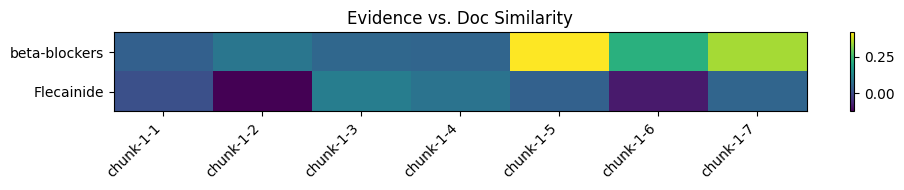

In [39]:
for i, res in enumerate(results):
    print(f"=== Result {i + 1} ===")
    print(f'Question: {res["question"]}')

    a = res['trace'].get("final_answer")
    html_out = "<h2>Answer</h2>"
    html_out += f"<p>{a}</p><hr>"

    result = res["explanation"]
    metrics = res["metrics"]
    cot_metrics = res["cot_metrics"]
    similarity = res["similarity"]
    documents = res["documents"]

    evidences = [ev.span for ev in result.evidence]
    supports = [s.split('-')[-1] for ev in result.evidence for s in ev.support]

    for i, d in enumerate(documents):
        doc_ids = []
        for support in supports:
            doc_id = support.split("-")[-1]
            doc_ids.append(doc_id)

        doc_id = f"{i + 1}"
        html_out += f"<h3>Document {highlight_text(doc_id, doc_ids)}</h3>"
        body = highlight_text(d.page_content, evidences)
        html_out += f"<pre>{body}</pre>"
    display(HTML(html_out))

    print("------------")
    print("Explain metrics:", metrics)
    print(cot_evaluator.prettify(cot_metrics))
    print(CoTExplainable.prettify(result))

    if similarity.get("scores"):
        scores = np.array(similarity["scores"])
        fig, ax = plt.subplots(figsize=(10, max(2, scores.shape[0] * 0.5)))
        im = ax.imshow(scores, aspect="auto", cmap="viridis")
        ax.set_xticks(range(len(similarity["doc_ids"])))
        ax.set_xticklabels(similarity["doc_ids"], rotation=45, ha="right")
        labels = []
        for span in similarity["evidence_spans"]:
            span = span.replace("\n", " ").strip()
            labels.append(span[:40] + "..." if len(span) > 40 else span)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        fig.colorbar(im, ax=ax)
        ax.set_title("Evidence vs. Doc Similarity")
        plt.tight_layout()
        plt.show()
    else:
        print("No similarity matrix to plot.")

# Simple German QA Dataset

Documents are created for each sentence. 

In [21]:
from src.evaluation.simple_qa_dataset import get_all_contexts_as_documents, get_dataset

dataset = get_dataset()
all_documents = get_all_contexts_as_documents()

explainer = CoTExplainable(llm_client=explain_client)

results = []
for i, item in enumerate(dataset):
    documents = all_documents[i][1]

    evidence = item["evidence"]
    question_text = item["question"]
    answer_prompt = client._create_final_answer_prompt(question_text, _format_documents(documents, from_query=question_text), extra="""
        Only answer based on your context not your knowledge. 
        Do not include any explanations, reasoning, or extra fields.
        
        Answer the question directly. Do not quote the context. Answer in German
        Example: Final Answer: Housing
    """)
    final_answer_response = client._base_llm.invoke(answer_prompt)
    final_answer = final_answer_response.content.strip()

    gt = item["answer"]

    explanation = explainer.explain(query=question_text, answer=final_answer, documents=documents)
    metrics = explainer.metrics()
    cot_metrics = cot_evaluator.evaluate(explanation, documents, ground_truth=gt, predicted_answer=final_answer, ground_truth_evidence=evidence)
    similarity = cot_evaluator.similarity_matrix(explanation, documents)
    
    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "explanation": explanation,
            "metrics": metrics,
            "cot_metrics": cot_metrics,
            "similarity": similarity,
            "documents": documents,
        }
    )

=== Result 1 ===
Welche Autofarbe hat Tom?


------------
Explain metrics: {'duration_seconds': 31.232269667088985, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9675
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9675
  • Max Entailment: 0.9675
  • Avg Neutral: 0.0276
  • Avg Contradiction: 0.0049
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.967)
        "Tom hat ein blaues Auto"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 5 tokens
  • Union: 5 tokens

evidence: Tom hat ein blaues Auto
  support: chunk-1-2
  rationale: chunk-1-2 directly states that Tom has a blue car.
Reasoning steps:
    step 1: Tom has a blue car.
      quote: Tom hat ein blaues Auto.


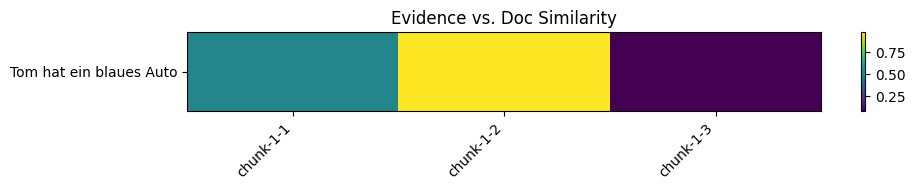

=== Result 3 END ===
=== Result 2 ===
Welches Haustier hat Anna?


------------
Explain metrics: {'duration_seconds': 33.978891250211746, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9723
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9723
  • Max Entailment: 0.9723
  • Avg Neutral: 0.0213
  • Avg Contradiction: 0.0065
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.972)
        "Anna besitzt eine Katze"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 4 tokens
  • Union: 4 tokens

evidence: Anna besitzt eine Katze
  support: chunk-1-2
  rationale: chunk-1-2 states that Anna owns a cat.
Reasoning steps:
    step 1: Anna owns a cat.
      quote: Anna besitzt eine Katze.


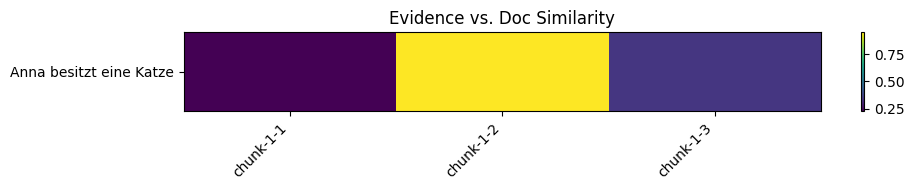

=== Result 3 END ===
=== Result 3 ===
Was ist der Beruf von Sarah?


------------
Explain metrics: {'duration_seconds': 38.67901379195973, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0066
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0066
  • Max Entailment: 0.0066
  • Avg Neutral: 0.9933
  • Avg Contradiction: 0.0002
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.007)
        "Sarah arbeitet als Lehrerin"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.5714
  • Intersection: 4 tokens
  • Union: 7 tokens

evidence: Sarah arbeitet als Lehrerin
  support: chunk-1-1
  rationale: chunk-1-1 directly states Sarah's profession as a teacher.
Reasoning steps:
    step 1: Sarah's profession is stated as a teacher.
      quote: Sarah arbeitet als Lehrerin


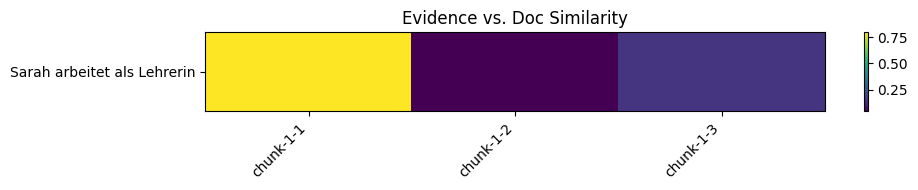

=== Result 3 END ===
=== Result 4 ===
Wo wohnt Klaus?


------------
Explain metrics: {'duration_seconds': 32.9113296251744, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9935
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9935
  • Max Entailment: 0.9935
  • Avg Neutral: 0.0058
  • Avg Contradiction: 0.0007
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.994)
        "Klaus wohnt in Berlin"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 4 tokens
  • Union: 4 tokens

evidence: Klaus wohnt in Berlin
  support: chunk-1-1
  rationale: chunk-1-1 directly states Klaus's residence is Berlin.
Reasoning steps:
    step 1: Klaus wohnt in Berlin.
      quote: Klaus wohnt in Berlin.


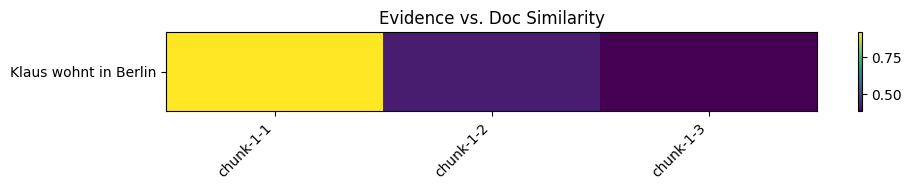

=== Result 3 END ===
=== Result 5 ===
Welches Hobby hat Julia?


------------
Explain metrics: {'duration_seconds': 38.01529733417556, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9576
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9576
  • Max Entailment: 0.9576
  • Avg Neutral: 0.0367
  • Avg Contradiction: 0.0057
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.958)
        "Julia spielt gerne Tennis am Wochenende."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 6 tokens
  • Union: 6 tokens

evidence: Julia spielt gerne Tennis am Wochenende.
  support: chunk-1-1
  rationale: chunk-1-1 directly states Julia's hobby is playing tennis on weekends.
Reasoning steps:
    step 1: Julia's hobby is playing tennis on weekends.
      quote: Julia spielt gerne Tennis am Wochenende.


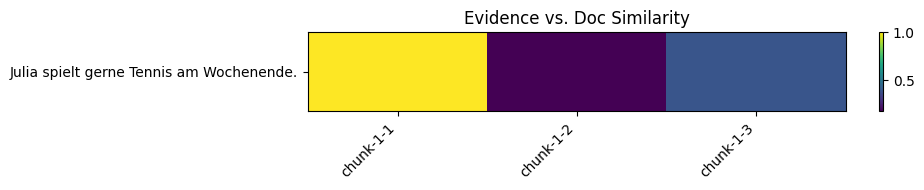

=== Result 3 END ===
=== Result 6 ===
Was ist Marks Lieblingsessen?


------------
Explain metrics: {'duration_seconds': 33.925612166989595, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9334
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9334
  • Max Entailment: 0.9334
  • Avg Neutral: 0.0571
  • Avg Contradiction: 0.0095
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.933)
        "Nudeln"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.0000
  • Intersection: 0 tokens
  • Union: 14 tokens

evidence: Nudeln
  support: chunk-1-2
  rationale: chunk-1-2 states that Mark only liked noodles as a child.
Reasoning steps:
    step 1: Mark liked noodles as a child.
      quote: Als Kind mochte er nur Nudeln.


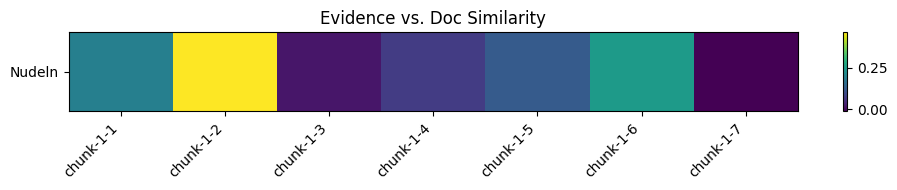

=== Result 7 END ===
=== Result 7 ===
Ist Emma noch minderjährig?


------------
Explain metrics: {'duration_seconds': 33.90621570777148, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9922
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9922
  • Max Entailment: 0.9922
  • Avg Neutral: 0.0054
  • Avg Contradiction: 0.0023
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.992)
        "Emma wurde 1998 geboren"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.3333
  • Intersection: 4 tokens
  • Union: 12 tokens

evidence: Emma wurde 1998 geboren
  support: chunk-1-1
  rationale: The document directly states Emma's birth year.
Reasoning steps:
    step 1: Emma wurde 1998 geboren.
      quote: Emma wurde 1998 geboren


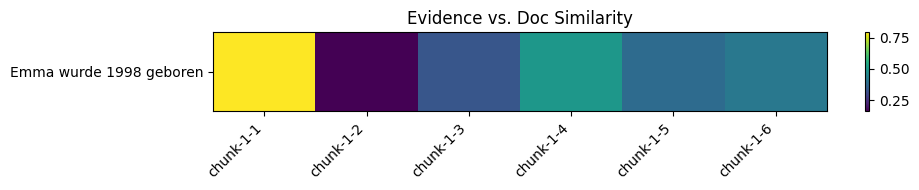

=== Result 6 END ===
=== Result 8 ===
Wie heißen David seine Kinder?


------------
Explain metrics: {'duration_seconds': 41.441088624764234, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.8058
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.8058
  • Max Entailment: 0.8058
  • Avg Neutral: 0.0822
  • Avg Contradiction: 0.1120
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.806)
        "Max und Lisa"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.1500
  • Intersection: 3 tokens
  • Union: 20 tokens

evidence: Max und Lisa
  support: chunk-1-4, chunk-1-5
  rationale: The answer states that David's children are Max and Lisa, which is directly supported by chunk-1-4 and chunk-1-5.
Reasoning steps:
    step 1: David has two children, Max and Lisa.
      quote: Davids Sohn Max ist 12 Jahre alt und spielt gerne Fußball.


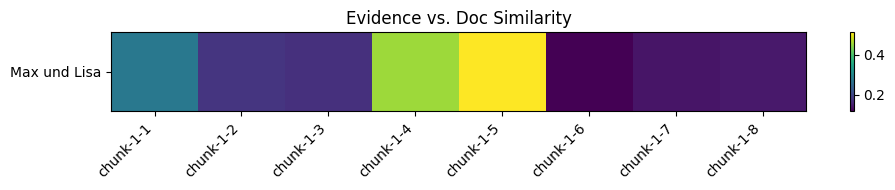

=== Result 8 END ===
=== Result 9 ===
Wohin reist Maria in den Urlaub?


------------
Explain metrics: {'duration_seconds': 32.7611916246824, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9816
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9816
  • Max Entailment: 0.9816
  • Avg Neutral: 0.0167
  • Avg Contradiction: 0.0017
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.982)
        "Nach Barcelona"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.1538
  • Intersection: 2 tokens
  • Union: 13 tokens

evidence: Nach Barcelona
  support: chunk-1-6
  rationale: The answer states Maria booked flights to Barcelona.
Reasoning steps:
    step 1: Maria hat sich letztendlich für Flüge nach Barcelona entschieden.
      quote: Flüge nach Barcelona gebucht.


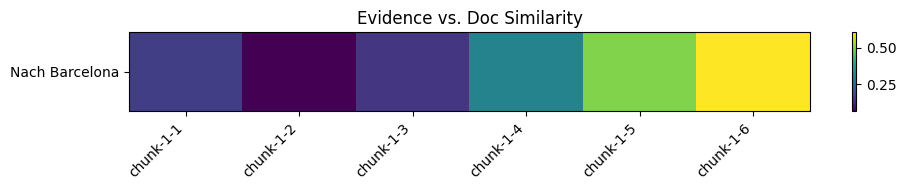

=== Result 6 END ===
=== Result 10 ===
Welche Sportart betreibt Tim?


------------
Explain metrics: {'duration_seconds': 54.85185108426958, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0164
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0087
  • Max Entailment: 0.0164
  • Avg Neutral: 0.7730
  • Avg Contradiction: 0.2183
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.001)
        "Tim betreibt Fußball im Verein TSV München seit vier Jahren"
    [1] NEUTRAL (ent: 0.016)
        "Tim's father plays golf every Sunday at the country club."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.3750
  • Intersection: 9 tokens
  • Union: 24 tokens

evidence: Tim betreibt Fußball im Verein TSV München seit vier Jahren
  support: chunk-1-6
  rationale: Document chunk-1-6 states that Tim trains football in the TSV Munich club for four years.
Reasoning steps:
    step 1: Tim trainiert Fußball im Verein TSV München seit vier Jahren.
      quote: Seit vier Jahren trainiert Tim Fußball im Ve

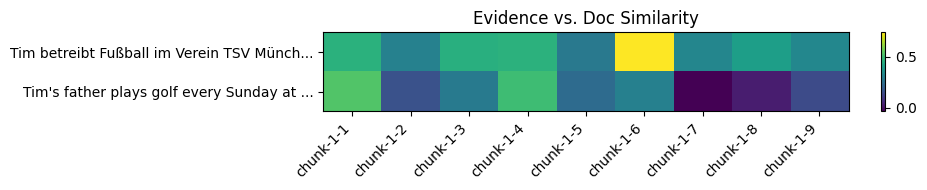

=== Result 9 END ===


In [34]:
for i, res in enumerate(results):
    print(f"=== Result {i + 1} ===")
    print(res["question"])
    a = res['final_answer']
    html_out = "<h2>Answer</h2>"
    html_out += f"<p>{a}</p><hr>"

    result = res["explanation"]
    metrics = res["metrics"]
    cot_metrics = res["cot_metrics"]
    similarity = res["similarity"]
    documents = res["documents"]

    evidences = [ev.span for ev in result.evidence]
    supports = [s.split('-')[-1] for ev in result.evidence for s in ev.support]

    for i, d in enumerate(documents):
        doc_ids = []
        for support in supports:
            doc_id = support.split("-")[-1]
            doc_ids.append(doc_id)

        doc_id = f"{i + 1}"
        html_out += f"<h3>Document {highlight_text(doc_id, doc_ids)}</h3>"
        body = highlight_text(d.page_content, evidences)
        html_out += f"<pre>{body}</pre>"
    display(HTML(html_out))
    
    print("------------")
    print("Explain metrics:", metrics)
    print(cot_evaluator.prettify(cot_metrics))
    print(CoTExplainable.prettify(result))

    if similarity.get("scores"):
        scores = np.array(similarity["scores"])
        fig, ax = plt.subplots(figsize=(10, max(2, scores.shape[0] * 0.5)))
        im = ax.imshow(scores, aspect="auto", cmap="viridis")
        ax.set_xticks(range(len(similarity["doc_ids"])))
        ax.set_xticklabels(similarity["doc_ids"], rotation=45, ha="right")
        labels = []
        for span in similarity["evidence_spans"]:
            span = span.replace("\n", " ").strip()
            labels.append(span[:40] + "..." if len(span) > 40 else span)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        fig.colorbar(im, ax=ax)
        ax.set_title("Evidence vs. Doc Similarity")
        plt.tight_layout()
        plt.show()
    else:
        print("No similarity matrix to plot.")


    print(f"=== Result {i + 1} END ===")

## Qualitative Evaluation

Es gibt zwei Bereiche:
- CoT Explaination auf MedMCQA-Datensatz
- CoT Explaination auf eigenen simplen QA Datensatz

Pro Antwort siehst du:
- Die Frage
- Die Antwort
- Pro Dokument highlighting welches Dokument laut LLM wichtig war
- Pro Dokument highlighting welche Stelle relevant war
    - Wenn kein Highlight existiert:
        - Ganz unten in der Ausgabe gibt es eine Liste mit evidence, support, rationale.
        - Evidence kann eventuell doch in den Dokumenten teilweise auftauchen. Das Highlighting hab ich nicht mehr hinbekommen / gewusst wie ich das schön mache.

- Explain metrics: Gibt dir Dauer und Anzahl an LLM Steps an
- Eine Grafik die zeigt "wie sehr" die Evidence in einem Dokument auftaucht
    - man kann das auch mit "support" vergleichen und sieht dass da sehr oft bs als "support" steht.